In [3]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import re, math
from collections import defaultdict

In [115]:
df = pd.read_json('bgg_data_clean.json',orient='split')
df.tail(15)

,year,age,num_players,duration,poll_age,poll_numpl,num_rated,rating,owned,attrs
343121,2021,7,"[1, 1]","[20.0, 15.0, 20.0]",[],"[[1, [None, None, None]]]",9,9.00000,8,"[Print & Play, Sports, Dice, Solitaire Only Ga..."
343129,2021,12,"[1, 2]","[90.0, 30.0, 90.0]","[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [1, 0, 0]], [2, [0, 1, 0]], [2, [0, 0, 1]]]",3,7.66667,12,"[Print & Play, World War II, Solo / Solitaire ..."
343130,2021,14,"[2, 4]","[60.0, 45.0, 60.0]",[],"[[4, [None, None, None]]]",1,8.00000,0,"[Set Collection, Card Game, Traditional Card G..."
343139,2021,5,"[2, 2]","[90.0, 30.0, 90.0]",[],"[[2, [None, None, None]]]",1,8.00000,0,"[Pattern Recognition, Territory Building, Grid..."
343152,2020,8,"[2, 4]","[40.0, 20.0, 40.0]",[],"[[4, [None, None, None]]]",1,7.00000,1,"[Set Collection, Puzzle, Drafting, Card Game, ..."
343208,2021,12,"[1, 1]","[45.0, 30.0, 45.0]",[],"[[1, [None, None, None]]]",2,8.00000,2,"[Set Collection, Print & Play, Solo / Solitair..."
343228,2021,8,"[2, 4]","[30.0, 15.0, 30.0]",[],"[[4, [None, None, None]]]",1,9.00000,0,"[Pattern Building, Abstract Strategy]"
343277,2021,10,"[1, 4]","[45.0, 30.0, 45.0]",[],"[[1, [0, 0, 0]], [2, [0, 0, 0]], [3, [0, 0, 0]...",5,7.40000,87,"[Drafting, Puzzle, Expansion for Base-game, Gr..."
343282,2021,7,"[2, 5]","[0.0, 0.0, 0.0]",[],"[[5, [None, None, None]]]",1,10.00000,2,"[Player Elimination, Hot Potato, Hand Manageme..."
343305,2020,10,"[1, 99]","[90.0, 30.0, 90.0]",[],"[[30, [None, None, None]]]",1,8.00000,1,"[Miniatures, Expansion for Base-game, Dice, Va..."


In [116]:
len(df)

71370

In [117]:
mean_age = math.ceil(df[df['age']>0]['age'].mean())
print('mean_age:',mean_age)

mean_age: 11


In [118]:
df['age'] = df['age'].apply(lambda x: x if x > 0 else mean_age)

def fix_poll_age(poll_age,age):
    if len(poll_age)<1:
        return age
    s = 0
    n = 0
    for a,na in poll_age:
        s += a*na
        n += na
    if n<1:
        return age
    return s/n
    
df['poll_age'] = df.apply(lambda row: fix_poll_age(row['poll_age'],row['age']), axis=1)

df['num_players'] = df['num_players'].apply(lambda x: [
    x[0] if x[0] > 0 else 2,
    (x[1] if x[1] >= x[0] else 3) if x[1] > 0 else 3
])

def fix_poll_numpl(poll_numpl,numpl):
    min_n = 0
    max_n = 0
    for n,(b,r,nr) in poll_numpl:
        if  b is None:  b = 0
        if  r is None:  r = 0
        if nr is None: nr = 0
        if b+r > nr:
            if min_n < 1: min_n = n
            if max_n < n: max_n = n
    if min_n < 1:
        min_n = numpl[0]
    if max_n < min_n:
        max_n = max(min_n,numpl[1])
    return [min_n,max_n]
    
df['poll_numpl'] = df.apply(lambda row: fix_poll_numpl(row['poll_numpl'],row['num_players']), axis=1)

In [119]:
df.head(15)

,year,age,num_players,duration,poll_age,poll_numpl,num_rated,rating,owned,attrs
387,2000,10,"[3, 7]","[45.0, 45.0, 45.0]",10.500000,"[3, 7]",337,5.81844,697,"[Series, Hand Management, Bluffing, Card Game]"
475,2000,12,"[2, 5]","[90.0, 45.0, 90.0]",11.454545,"[3, 5]",7149,7.27751,8569,"[Region, Set Collection, Drafting, Hand Manage..."
478,2000,10,"[2, 8]","[60.0, 20.0, 60.0]",9.898396,"[2, 7]",49176,7.07999,65605,"[Drafting, Set Collection, Fantasy, Card Game,..."
481,2000,12,"[2, 4]","[60.0, 60.0, 60.0]",10.785714,"[2, 4]",3429,6.81879,3909,"[Territory Building, Area Majority / Influence..."
490,2000,12,"[2, 6]","[60.0, 60.0, 60.0]",10.200000,"[2, 6]",262,7.70292,340,"[Fantasy, Print & Play, Wargame, Grid, Dice, M..."
491,2000,12,"[3, 5]","[60.0, 50.0, 60.0]",10.666667,"[3, 5]",3369,7.29773,3211,"[Drafting, Territory Building, Area Majority /..."
492,2000,10,"[3, 5]","[90.0, 60.0, 90.0]",9.333333,"[3, 5]",3111,6.90465,3896,"[Region, Set Collection, Folk Tales, Fantasy, ..."
495,2000,10,"[3, 6]","[60.0, 60.0, 60.0]",18.000000,"[2, 5]",253,5.56482,512,"[Pirates, Set Collection, Theme]"
496,2000,10,"[3, 5]","[30.0, 30.0, 30.0]",10.000000,"[3, 5]",28,4.11429,97,"[Dexterity, Card Game]"
497,2000,10,"[3, 5]","[30.0, 30.0, 30.0]",6.125000,"[3, 5]",606,5.92659,880,"[Set Collection, Card Game, Creatures, Hand Ma..."


array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

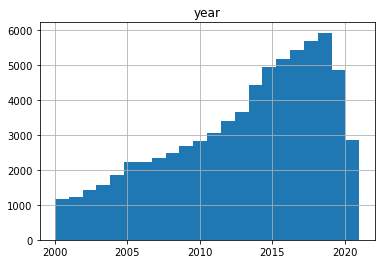

In [97]:
num_years, year_min, year_max = [ x for x in df.agg({'year': ['nunique','min','max']})['year'] ]
df.hist('year', bins=num_years)

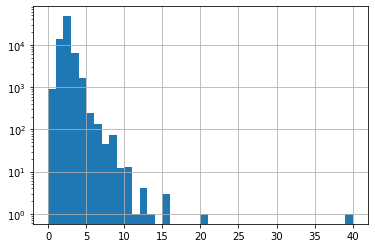

In [89]:
min_num_players = df['num_players'].apply( lambda x: x[0] )
xnum, xmin, xmax = [ x for x in min_num_players.agg(['nunique','min','max']) ]
min_num_players.hist(bins=xmax)
plt.yscale('log')

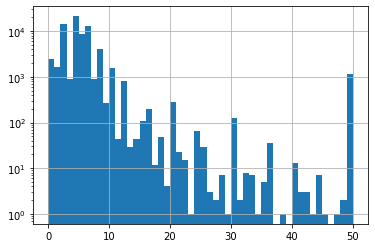

In [88]:
max_num_players = df['num_players'].apply( lambda x: x[1] if x[1] < 50 else 50 )
xnum, xmin, xmax = [ x for x in max_num_players.agg(['nunique','min','max']) ]
max_num_players.hist(bins=xmax)
plt.yscale('log')

In [117]:
mean_age = math.ceil(df[df['age']>0]['age'].mean())
print('mean_age:',mean_age)

mean_age: 11


min      0.000000
max     11.968323
mean     3.068150
Name: duration, dtype: float64


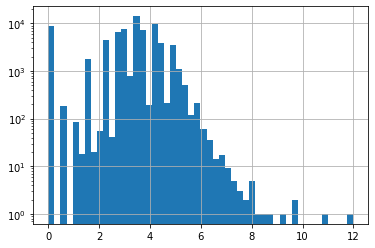

In [147]:
duration = df['duration'].apply( lambda x: math.log(x[1]) if x[1]>0 else 0 )
print(duration.agg(['min','max','mean']))
duration.hist(bins=50)
plt.yscale('log')

In [120]:
df.groupby('year').agg({'rating': ['mean','std']})

rating          
          mean       std
year                    
2000  5.660384  1.470532
2001  5.591836  1.391118
2002  5.562540  1.465453
2003  5.679176  1.433479
2004  5.750640  1.427864
2005  5.654377  1.502711
2006  5.732919  1.498877
2007  5.791050  1.498736
2008  5.964450  1.524008
2009  6.100391  1.442727
2010  6.198713  1.477788
2011  6.261639  1.471741
2012  6.415115  1.476358
2013  6.552582  1.427857
2014  6.591100  1.441310
2015  6.692830  1.394701
2016  6.832938  1.428193
2017  6.997419  1.332614
2018  7.121440  1.303572
2019  7.283052  1.327032
2020  7.565039  1.301259
2021  7.859179  1.358018

In [121]:
class ScaleRatingByYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.m = {
            key: vals for key,*vals in
            X.groupby('year').agg({'rating':['mean','std']}).to_records()
        }
        return self
    def transform(self, X):
        def scale(x):
            mean, std = self.m[x[0]]
            return (x[1]-mean)/std
        return X[['year','rating']].apply(scale,axis=1)

In [122]:
# scaled_rating = ScaleRatingByYear().fit_transform(df)
df['scaled_rating'] = ScaleRatingByYear().fit_transform(df)
# print(scaled_rating)
# df.groupby('year').agg({'scaled_rating': ['mean','std']})

In [123]:
class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for xs in X:
            yield { x: 1 for x in xs }

In [124]:
binary_encoder = Pipeline([
    ('encode',   DictEncoder()),
    ('vectorize',DictVectorizer(sparse=False))
])
X_all = Pipeline([
    ('attrs',ColumnTransformer([
        ('attrs',binary_encoder,'attrs'),
    ]))
]).fit_transform(df)
X_all

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
y_all = df['scaled_rating'].to_numpy()

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.35, random_state=123)

In [127]:
model = Pipeline([
    ('PCA',PCA(n_components=2))
])
# model.fit(X_train)
X_pca = model.fit_transform(X_train)

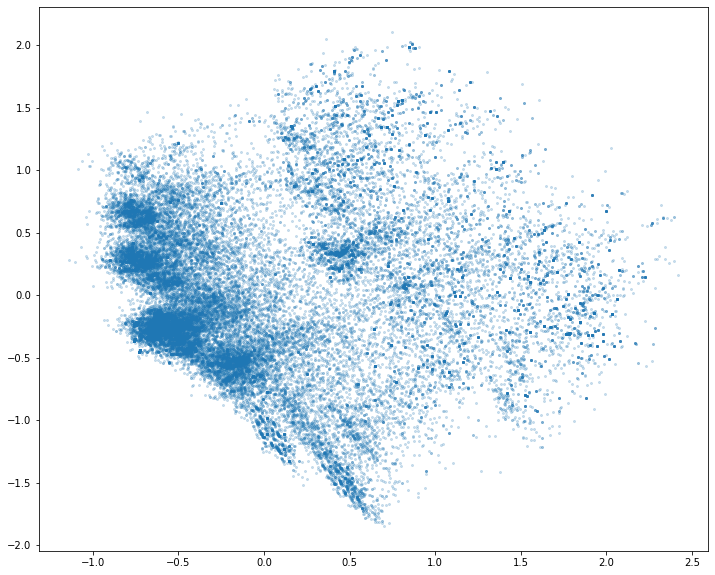

In [128]:
plt.gcf().set_size_inches(12,10)
plt.scatter(X_pca[:,0], X_pca[:,1], s=4, alpha=0.2)

In [129]:
pca = PCA()
pca.fit(X_all)

PCA()

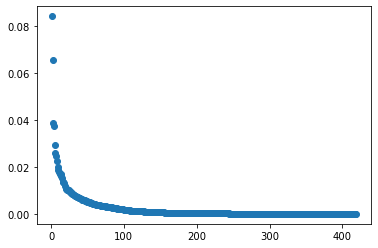

In [130]:
pca_expl = pca.explained_variance_ratio_
plt.plot(range(1,len(pca_expl)+1),pca_expl,'o')

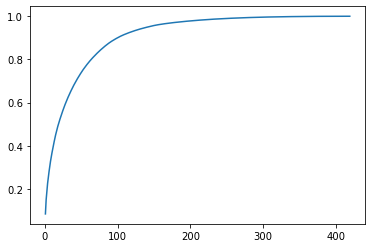

In [131]:
plt.plot(range(1,len(pca_expl)+1),np.cumsum(pca_expl),'-')

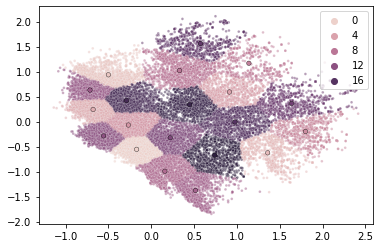

In [132]:
km = KMeans(n_clusters=20)
km.fit(X_pca)

ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=km.labels_, alpha=0.5, s=7)
ax = sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1],
                     hue=range(km.n_clusters), s=20, ec='black', legend=False, ax=ax)

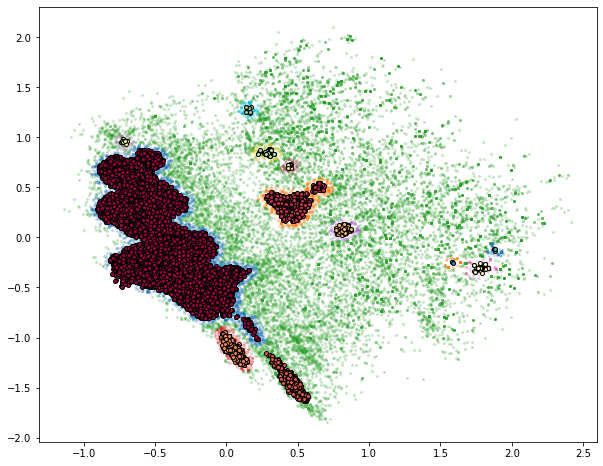

In [133]:
db = DBSCAN(eps=0.06,min_samples=100)
db.fit(X_pca)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

plt.gcf().set_size_inches(10,8)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

    xy = X_pca[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=4, alpha=0.2)